In [1]:
#Part1 测试label数据
import json

#导入Json数据
with open("./data/mchar_train.json",'r') as mchar_train:
    mchar_train = json.load(mchar_train)
with open("./data/mchar_val.json",'r') as mchar_val:
    mchar_val = json.load(mchar_val)

import pandas as pd
mchar_train = pd.DataFrame(mchar_train) #pandas后的json数据
mchar_val = pd.DataFrame(mchar_val)

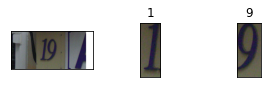

In [2]:
#Part2 测试image数据
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
train_json = json.load(open("./data/mchar_train.json"))

# 数据标注,切割处理
def parse_json(d):
    arr = np.array([
        d['top'], d['height'], d['left'],  d['width'], d['label']
    ])
    arr = arr.astype(int)
    return arr

img = cv2.imread('./data/mchar_train/mchar_train/000000.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Opencv默认颜色通道为BGR，需要转换
arr = parse_json(train_json['000000.png'])

plt.figure(figsize=(5, 1)) #figsize = (width,height)
plt.subplot(1, arr.shape[1]+1, 1) #subplot(行数，列数，位置)
plt.imshow(img)
plt.xticks([]); plt.yticks([]) #xticks()中填入数字，如[0，10，20，30]可以显示刻度

for idx in range(arr.shape[1]):
    plt.subplot(1, arr.shape[1]+1, idx+2)
    plt.imshow(img[arr[0, idx]:arr[0, idx]+arr[1, idx],arr[2, idx]:arr[2, idx]+arr[3, idx]]) #img[top:top+height,left:left+width] 
    plt.title(arr[4, idx])
    plt.xticks([]); plt.yticks([])

In [3]:
#Part3 定义数据集
from ctypes.wintypes import INT, LONG
import os, sys, glob, shutil, json
from pickletools import long1, long4
import cv2

from PIL import Image
import numpy as np

import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 原始SVHN中类别10为数字0
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (6 - len(lbl)) * [10] #将lbl用数字10填充至6个
        
        return img, torch.from_numpy(np.array(lbl[0:6]))

    def __len__(self):
        return len(self.img_path)

train_path = glob.glob('C:/Project/python/Jupyter/Practise/tianchi/data/mchar_train/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('C:/Project/python/Jupyter/Practise/tianchi/data/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)), #固定尺寸
                       transforms.ColorJitter(0.3, 0.3, 0.2), #随机颜色变换
                       transforms.RandomRotation(5), #随机旋转
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=1, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=0 # 读取的线程个数
)

val_path = glob.glob('C:/Project/python/Jupyter/Practise/tianchi/data/mchar_val/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('C:/Project/python/Jupyter/Practise/tianchi/data/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

val_loader = torch.utils.data.DataLoader(
        SVHNDataset(val_path, val_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)), #固定尺寸
                       transforms.ColorJitter(0.3, 0.3, 0.2), #随机颜色变换
                       transforms.RandomRotation(5), #随机旋转
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=10, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=0 # 读取的线程个数
)



In [4]:

#Part4 定义模型
import torch
torch.manual_seed(0) #固定随机数种子，确保参数（训练效果）一致
torch.backends.cudnn.deterministic = False #GPU使用默认算法
torch.backends.cudnn.benchmark = True #GPU寻找最优算法

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

# 定义模型
class SVHN_Model1(nn.Module): #输入数据为3x64x128
    def __init__(self):
        super(SVHN_Model1, self).__init__() #super()可以理解为指向父类的指针
        # CNN提取特征模块
        self.cnn = nn.Sequential( #顺序构建网络
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)), #in_channel, out_channel, 卷积核大小, 滑动步长
            nn.ReLU(),  #非线性激活函数，为了避免神经网络中全部是线性函数，那样就不需要神经网络了
            nn.MaxPool2d(2), #最大池化MaxPooling，大小为2x2
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11) #有点问题
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
        self.fc5 = nn.Linear(32*3*7, 11)
        self.fc6 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        c6 = self.fc6(feat)
        return c1, c2, c3, c4, c5, c6 #返回c1~c6，6个tensor，每个tensor包括了0~10，11个数字的概率分布
    

model = SVHN_Model1()

In [5]:
#Part5 训练和验证模型
import time
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False) #求batch中的loss之和

# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0
val_loss, timer = [], []
val_mean_loss,train_mean_loss = [], []

def train(train_loader, model, criterion, optimizer, epoch):
    model.train() #启用batch normalization和drop out
    loss_can0 = []
    for images,labels in train_loader:  #train_loader中的数据分为两部分,data[0]表示图片，data[1]表示标识
        c0, c1, c2, c3, c4, c5 = model(images)
        loss = criterion(c0, torch.tensor(labels[:, 0],dtype=torch.long)) + \
                criterion(c1, torch.tensor(labels[:, 1],dtype=torch.long)) + \
                criterion(c2, torch.tensor(labels[:, 2],dtype=torch.long)) + \
                criterion(c3, torch.tensor(labels[:, 3],dtype=torch.long)) + \
                criterion(c4, torch.tensor(labels[:, 4],dtype=torch.long)) + \
                criterion(c5, torch.tensor(labels[:, 5],dtype=torch.long))
        loss /= 6 #计算损失函数,6个数字全部对上损失=0，全部不对损失=1
        loss_can0.append(loss.item())
        optimizer.zero_grad() #清零现有梯度
        loss.backward() #当前梯度后向传递
        optimizer.step() #更新权值
    train_mean_loss.append(np.mean(loss_can0))#求每个epoch的平均loss
        
def validate(val_loader, model, criterion):
    model.eval()
    loss_can1 = []
    with torch.no_grad():
        for images,labels in val_loader:  
            c0, c1, c2, c3, c4, c5 = model(images)
            loss = criterion(c0, torch.tensor(labels[:, 0],dtype=torch.long)) + \
                    criterion(c1, torch.tensor(labels[:, 1],dtype=torch.long)) + \
                    criterion(c2, torch.tensor(labels[:, 2],dtype=torch.long)) + \
                    criterion(c3, torch.tensor(labels[:, 3],dtype=torch.long)) + \
                    criterion(c4, torch.tensor(labels[:, 4],dtype=torch.long)) + \
                    criterion(c5, torch.tensor(labels[:, 5],dtype=torch.long))
            loss /= 6 #计算损失函数,6个数字全部对上损失=0，全部不对损失=1

            val_loss.append(loss.item()) #误差损失
            loss_can1.append(loss.item())
    val_mean_loss.append(np.mean(loss_can1))#求每个epoch的平均loss
    return np.mean(val_loss) #list类型，变为一个numpy数字


# 迭代30个Epoch
for epoch in range(30):
    time_start = time.time()
    train(train_loader, model, criterion, optimizer, epoch)
    loss1 = validate(val_loader, model, criterion)
    
    if loss1 < best_loss:
        best_loss = loss1
        torch.save(model.state_dict(),'./model.pt')
        
    time_end = time.time()
    time_cost = time_end - time_start
    timer.append(time_cost)
    print("epoch%d,time_cost = %d" %(epoch,time_cost))

    

c:\software\python3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\62708\AppData\Local\Temp\ipykernel_15012\1557690707.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lbl = np.array(self.img_label[index], dtype=np.int)
C:\Users\62708\AppData\Local\Temp\ipykernel_15012\4281304098.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.c

epoch0,time_cost = 655
epoch1,time_cost = 421
epoch2,time_cost = 365
epoch3,time_cost = 405
epoch4,time_cost = 636
epoch5,time_cost = 837
epoch6,time_cost = 846
epoch7,time_cost = 803
epoch8,time_cost = 793
epoch9,time_cost = 802
epoch10,time_cost = 764
epoch11,time_cost = 744
epoch12,time_cost = 742
epoch13,time_cost = 554
epoch14,time_cost = 335
epoch15,time_cost = 333
epoch16,time_cost = 332
epoch17,time_cost = 333
epoch18,time_cost = 333
epoch19,time_cost = 332
epoch20,time_cost = 333
epoch21,time_cost = 332
epoch22,time_cost = 332
epoch23,time_cost = 334
epoch24,time_cost = 329
epoch25,time_cost = 329
epoch26,time_cost = 332
epoch27,time_cost = 332
epoch28,time_cost = 337
epoch29,time_cost = 335


In [6]:
#Part6 模型保存
#保存模型
#torch.save(model.state_dict(),'./model.pt')
#读取模型
#model = SVHN_Model1()
#model.load_state_dict(torch.load('./model.pt'))

In [32]:
#Part7 模型测试
import pandas as pd
import sys
#from torchvision.transforms import ToTensor
#from torchvision.transforms import Resize

predict,all_path = [],[]
test_glob = glob.glob('C:/Project/python/Jupyter/Practise/tianchi/data/mchar_test_a/mchar_test_a/*.png') #批量读取文件名到列表
for test_path in test_glob:
    img = Image.open(test_path).convert('RGB')
    img=img.resize((128, 64))
    totensor = transforms.ToTensor()  #将PIL image或ndarray类型变换成tensor形式
    tensor0 = totensor(img)
    
    torch_norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    tensor0 = torch_norm(tensor0)
    tensor0 = Variable(torch.unsqueeze(tensor0, dim=0).float(), requires_grad=False)

    c0, c1, c2, c3, c4, c5 = model(tensor0)
    pre = [c0, c1, c2, c3, c4, c5]
    
    c0_pre = ((c0.tolist())[0]).index(max((c0.tolist())[0]))#debug发现是二维结构
    c1_pre = ((c1.tolist())[0]).index(max((c1.tolist())[0]))
    c2_pre = ((c2.tolist())[0]).index(max((c2.tolist())[0]))
    c3_pre = ((c3.tolist())[0]).index(max((c3.tolist())[0]))
    c4_pre = ((c4.tolist())[0]).index(max((c4.tolist())[0]))
    c5_pre = ((c5.tolist())[0]).index(max((c5.tolist())[0]))
    
    pre = [c0_pre, c1_pre, c2_pre, c3_pre, c4_pre, c5_pre]
    pre_b = []
    for i in pre:
        if i != 10:
            pre_b.append(i)
    print(pre_b)
    if pre_b is not None:
        pre_b = ''.join(str(s) for s in pre_b) #转化为字符串
    predict.append(pre_b)
    test_path = test_path.replace('C:/Project/python/Jupyter/Practise/tianchi/data/mchar_test_a/mchar_test_a\\','')
    all_path.append(test_path)
data = {'file_name':all_path,'file_code':predict}
df = pd.DataFrame(data)
df.to_excel("./predict.xlsx")


[4, 8]
[8, 6]
[1]
[1, 3, 3]
[4, 2]
[2, 2, 5]
[2, 2]
[1, 3]
[1, 1]
[3, 7, 7, 2]
[2, 2, 0]
[4, 5]
[2, 2, 2]
[4]
[1, 7]
[2, 3]
[6, 0]
[4, 2]
[5, 2]
[2, 2]
[2, 2]
[5, 6, 6]
[3, 2]
[2]
[3, 6]
[2, 0, 0]
[3, 7]
[2, 4, 2]
[2, 5]
[1, 5]
[2]
[2, 7]
[1, 2]
[4, 3]
[2, 0]
[1, 1]
[2, 4]
[1, 9]
[6, 2]
[1, 0, 7]
[2, 2, 8]
[5, 2]
[1, 0]
[1, 5, 6]
[1, 0, 0]
[1, 3]
[4, 4, 2]
[1, 6, 8]
[1, 0, 0]
[1, 0, 0]
[3, 6]
[4, 4]
[1, 2]
[5, 5]
[4, 5]
[1, 7, 7]
[2, 3, 3]
[7, 7, 6]
[3, 6]
[1, 3]
[1, 9]
[3, 1]
[1, 4]
[2, 5]
[4, 4]
[1, 0, 0]
[6, 7]
[4, 5]
[4, 4]
[1, 7]
[8, 2]
[5, 3]
[1, 3]
[2, 5]
[3, 5]
[1, 0]
[1, 2, 3]
[4, 2]
[1, 2]
[4, 9]
[4, 0]
[3, 2, 2]
[7, 2]
[1, 5]
[3, 9]
[1, 6, 5]
[4, 2]
[2]
[2, 5]
[1, 5]
[2, 2, 2]
[1, 0]
[2, 3]
[1, 2]
[4, 3]
[1, 6]
[6, 0]
[1, 2]
[3, 7]
[3, 0, 0]
[3, 2]
[1]
[2, 8]
[3, 3]
[2, 2]
[1, 3, 3]
[3, 5, 6]
[2, 0]
[1, 2]
[4, 7]
[2, 2]
[2, 2]
[1, 3]
[2]
[1, 3]
[1, 6]
[1, 5]
[2, 4]
[1, 0]
[1, 3]
[2, 3]
[2, 9, 9, 9]
[2, 2]
[5, 3]
[4]
[1]
[2]
[1, 6, 6]
[2, 2, 3]
[1, 3]
[1, 8]
[2, 0, 7]
[1, 6]


[1, 7]
[2, 5]
[2, 2]
[1]
[1, 6, 5]
[2, 7]
[1, 0]
[1, 2]
[2, 2]
[3, 7]
[1, 2, 3]
[3, 7, 7]
[3, 5]
[2, 3]
[1, 2, 7]
[3, 2]
[4, 6]
[2, 2]
[2, 2]
[1, 1, 2]
[2, 3]
[2, 7]
[2, 7]
[2, 2, 2]
[2, 2]
[9, 1]
[1]
[1, 7]
[3, 6, 0]
[3, 7]
[1, 0, 4]
[3, 5, 3]
[6, 5]
[3, 0]
[4, 2, 7]
[2, 4]
[1, 0]
[2, 3, 3]
[3, 2]
[7, 7]
[1, 7, 6]
[3, 5, 5]
[1, 6]
[1, 6]
[1]
[4, 3, 5]
[1, 4]
[1, 9]
[1]
[1, 4, 4]
[2]
[5, 1]
[2, 2, 2]
[2, 6]
[4, 5, 3, 5]
[2]
[3, 3, 0]
[1, 4]
[4]
[2, 2, 7]
[6, 6]
[1, 2, 3]
[1, 3]
[1, 2]
[6, 3]
[2, 4, 4]
[2, 8, 8]
[1]
[3, 3]
[1, 2]
[2]
[2, 2, 7, 7]
[4, 0]
[3, 2, 7]
[1, 7]
[4, 0]
[2, 2, 5]
[1, 1]
[3, 9]
[3, 0]
[1, 4, 4]
[2, 5]
[2, 8]
[2, 2]
[1, 1, 0]
[6, 6]
[1, 2]
[8, 1, 9, 9]
[2, 4, 0]
[1, 3]
[1, 3]
[2]
[2, 2]
[4, 9]
[3, 5, 5]
[1, 2]
[1, 9, 5]
[1]
[5, 1]
[1, 0]
[1, 7]
[1, 3]
[2, 6, 5]
[1, 0, 0]
[7, 2]
[4, 7, 0]
[7, 6, 3]
[1, 0]
[2, 8]
[3, 3, 6]
[2, 6, 6]
[7, 2, 7, 7]
[4, 0, 0]
[1]
[9, 1]
[3, 7, 7]
[6, 6]
[5, 5]
[6, 3]
[1, 6, 7]
[2, 6, 6]
[5, 3]
[2, 3]
[1, 3]
[2, 7]
[7]
[5, 2, 4]
[4, 4]
[1

[3, 2]
[1, 6]
[2]
[2, 1]
[4]
[2, 7]
[2]
[3, 1]
[1, 9]
[4, 3]
[1, 0]
[1, 3, 6]
[1, 2]
[3, 5]
[1]
[2, 2]
[1, 5]
[1, 2, 7]
[3, 0]
[1, 0]
[2, 3, 5]
[3, 5]
[1, 3]
[2, 4]
[1, 1]
[1, 4]
[2, 3, 3, 3]
[2, 2]
[1, 2]
[5, 3, 7]
[4, 7, 2]
[3, 5, 9]
[2, 7]
[4, 3]
[1]
[5, 1]
[6, 4]
[1, 2]
[2]
[2]
[1, 3]
[6, 7]
[2, 4, 4, 1]
[9, 0]
[1, 0]
[1, 2, 7]
[1, 2, 1]
[1, 6]
[2, 7]
[3, 7]
[2, 2]
[3, 7]
[1, 3, 5]
[2, 2, 5]
[1, 0]
[4, 2, 2]
[2]
[2, 4, 7, 7]
[1]
[2, 2, 2]
[2, 0]
[4]
[5, 1]
[2, 2, 3, 3]
[1, 9]
[2, 2]
[2, 2, 5]
[1, 7]
[2, 7, 6]
[5, 3, 3]
[4, 4]
[1, 4]
[1, 3, 0]
[2, 0, 8]
[1, 1]
[1, 6]
[5, 4]
[1, 9, 3]
[2]
[4, 5, 5, 5]
[2, 0]
[1]
[2, 6]
[2, 6, 0]
[1, 2]
[2, 2, 2]
[1]
[2, 4]
[5, 0, 0]
[1, 6, 2]
[1, 5, 5]
[3, 2]
[2, 8]
[2, 2]
[3, 0]
[1, 7]
[1, 3, 3]
[1]
[2, 3]
[6, 0]
[4, 6]
[5, 2, 2]
[3, 6]
[2, 2]
[4, 2]
[1]
[1, 0]
[1]
[1]
[2, 6]
[1, 7]
[2, 1]
[2, 1]
[2, 3]
[5, 7]
[5, 6]
[2, 1]
[1, 4]
[1, 0]
[6, 8]
[1, 8]
[2, 3]
[2, 3, 2, 0]
[1, 4]
[1, 2]
[6, 2, 6]
[5, 2]
[1, 2]
[2, 7]
[2, 3, 6]
[1, 9]
[3, 0]
[4]
[4, 3,

[2, 6]
[2, 3, 5]
[3]
[2]
[1, 5]
[1, 3]
[4, 2]
[5, 1]
[5, 6, 6]
[3, 1]
[2, 2]
[1, 2, 3]
[2, 7]
[2, 6]
[1]
[1, 2]
[2, 2]
[2, 0]
[2, 1, 0, 1]
[6, 5, 5]
[1, 6]
[3, 2, 6]
[2, 2]
[1, 2]
[7, 7]
[2, 5, 5, 5]
[1, 2]
[3, 4]
[6, 4]
[2, 5, 8, 9]
[1, 2, 8]
[1, 7]
[1, 9]
[1, 7]
[1, 2, 2]
[9, 0, 0]
[2, 5, 5]
[3, 4, 3]
[9, 1]
[4, 0]
[2]
[5, 5]
[1]
[1, 3]
[1, 7]
[2, 2, 2]
[3, 2]
[5, 5, 5]
[2, 7]
[1, 2]
[4]
[4, 2]
[4, 2]
[5, 5]
[4]
[1]
[3, 0]
[5, 5]
[3, 6]
[1, 2]
[8, 1, 1]
[1, 6]
[2, 2, 0]
[2, 6, 6]
[1, 2, 6]
[4, 9]
[1, 1]
[1, 1, 4]
[5, 2]
[3, 3, 7]
[1, 0, 3]
[4]
[3, 1]
[1, 4]
[3, 5]
[5, 3]
[1, 1]
[1]
[2]
[1, 6, 3]
[5, 5]
[1, 6, 3]
[5, 2]
[2, 2]
[3, 6]
[3, 1, 1]
[5, 2]
[2, 5]
[2, 2]
[2, 6, 8, 9]
[8, 4]
[4, 0, 0]
[1, 0, 7]
[4, 7]
[2, 2, 5]
[3, 2, 0]
[2, 7]
[3, 4]
[2]
[3, 0]
[2, 2]
[2, 2, 2]
[1, 2, 2]
[2, 1]
[2, 7]
[3, 9, 0]
[5, 1]
[4, 2, 0]
[1, 4, 3]
[3, 5]
[3, 5]
[2]
[5, 5]
[1, 2, 1]
[3, 1]
[2, 6]
[3, 6]
[3, 3]
[3, 5, 0]
[1, 5, 5]
[4, 6, 8]
[1, 0, 6]
[3, 1]
[1, 0]
[3, 1]
[7, 2]
[5, 5]
[1, 5]
[2, 2]
[2, 

[1, 3, 8]
[4, 0]
[3, 0]
[4, 4]
[1, 5]
[1, 5, 5]
[9, 6, 6]
[1, 0]
[7, 0]
[2, 9, 3]
[3, 4]
[1, 5, 5]
[1, 7, 7]
[3, 6]
[2, 7, 7]
[2, 7, 7]
[4, 4]
[2, 5, 3]
[1]
[1, 0, 7, 7]
[2, 2, 7]
[2, 2]
[1, 0]
[2, 3, 3]
[2, 0, 0]
[1, 4]
[3, 1]
[2, 2]
[4, 2]
[4, 2]
[1, 6]
[2, 7, 7]
[3, 6, 5]
[2]
[7]
[2, 2, 2]
[2, 3]
[1, 9]
[1, 2, 2]
[1, 6]
[1, 4]
[2, 7]
[1, 6, 6]
[6, 7]
[2, 5, 0]
[1, 0]
[2, 2]
[2, 3]
[4, 3]
[1]
[1, 4]
[2, 0]
[4, 4]
[1]
[7, 3]
[2, 0]
[1, 2]
[1, 4]
[2, 4]
[2, 6]
[1, 0]
[2]
[2, 2, 5]
[5, 3]
[4, 5]
[2, 2]
[2, 3]
[6, 5]
[1]
[2, 3, 0]
[1, 3]
[4, 9]
[6, 1]
[7]
[1, 5]
[3, 3]
[3, 3]
[1]
[1, 2]
[1, 2]
[2, 2]
[6, 2]
[1, 2, 2]
[2]
[2, 0]
[2, 2, 2]
[5, 8, 3]
[3, 9]
[2, 0]
[1, 0, 0]
[1, 2]
[3, 1]
[3, 2]
[4, 4]
[3, 0]
[2, 2]
[1]
[2, 3]
[1, 0, 0]
[2, 9]
[2, 0]
[2, 0, 0]
[1, 2]
[2, 7]
[1, 6]
[3, 3]
[2, 6]
[1, 1]
[4, 5]
[2, 0]
[2, 2, 3]
[3, 1]
[2, 1]
[3, 9]
[3, 1]
[6, 1, 7]
[1, 0]
[9]
[7, 7]
[2, 2, 7]
[1, 6, 5]
[3, 2]
[3, 3]
[2, 0]
[6, 6]
[7]
[1, 2, 3]
[1, 3, 8]
[2, 0]
[2, 3, 3, 4]
[1]
[2, 4]
[5, 3, 9]


[2, 4]
[3, 1]
[2]
[4, 4]
[2, 6]
[1]
[4, 2, 2]
[1]
[3, 7]
[5, 5]
[4, 2]
[2, 2]
[2, 7]
[2]
[5, 3]
[1, 6, 5]
[2, 9]
[1, 0, 9]
[5, 3]
[2, 2]
[1]
[2, 2, 7]
[1, 7]
[2, 0, 0]
[5, 5]
[1, 9]
[2, 2]
[1]
[3, 3]
[1]
[2, 6, 6]
[4, 6, 5]
[1, 3, 3]
[1, 6, 3, 3]
[1, 7]
[4, 2]
[3, 2]
[1, 2]
[6, 2]
[1, 6]
[3, 2]
[2, 5]
[2, 7]
[2, 5, 5]
[1, 4, 4, 4]
[2, 3]
[2]
[5, 6]
[1, 4, 0]
[2, 2, 0]
[2, 2, 4]
[1, 5, 5]
[1, 6, 6]
[1, 6]
[1, 0]
[2, 7]
[3, 3]
[2, 2, 2]
[5, 2]
[2, 3]
[1, 2]
[1, 2]
[1, 0, 0]
[1, 6]
[4, 5]
[5, 2]
[2, 6, 6]
[2, 3]
[1, 2, 2]
[9, 6]
[3, 7]
[1]
[1]
[8, 0]
[6, 2]
[1, 6]
[4, 5]
[1, 5]
[1, 1]
[5, 7]
[7, 2]
[2, 2]
[1, 3, 6, 7]
[1, 3, 3]
[1, 6, 5]
[2, 2]
[1, 4]
[3, 3]
[1, 2]
[4, 2]
[3, 3, 0, 0]
[2, 3, 3]
[1, 5]
[1, 6]
[3, 3]
[3, 9]
[1, 2, 7]
[1, 6, 5]
[1, 2, 2]
[3, 6]
[2, 2, 0]
[1, 6]
[3, 2, 2]
[1, 0]
[2, 3]
[9, 5]
[3, 2, 7, 7]
[1, 3]
[2, 0, 6]
[2, 2]
[1, 2, 7]
[3, 3]
[9, 1]
[1, 9]
[1, 9]
[2, 5]
[2, 2, 2]
[1, 6]
[2, 1]
[1, 2]
[4, 7]
[3, 3]
[4, 2]
[2, 6]
[2, 9]
[1, 2]
[1, 0, 7]
[1, 4, 4, 7]
[3, 5]
[

[2]
[2, 6, 6]
[2, 2]
[1, 6]
[2, 4]
[2]
[1, 7]
[5, 6]
[2, 5, 5]
[2, 7]
[1, 6]
[1, 2, 2]
[2]
[1, 0, 0]
[5, 2, 2]
[5, 7]
[3, 9]
[4, 0]
[6, 0]
[0]
[2, 2]
[4, 5]
[1]
[6, 1]
[1, 6, 6]
[5, 2]
[3, 4]
[1, 2, 2]
[2, 5]
[2, 5]
[2, 2]
[5, 3]
[1, 7]
[1, 3, 1]
[1, 3]
[3, 1, 1]
[4, 6]
[1, 1]
[7]
[1, 7]
[4]
[2, 1]
[2, 0]
[2, 3]
[6, 3, 5, 5]
[1]
[1, 0, 0]
[2]
[4, 0]
[5, 2]
[2, 6]
[5, 5]
[2, 4]
[1, 3]
[4, 4]
[1, 5, 5, 5]
[7]
[1, 4]
[1]
[1]
[2]
[6, 3]
[4, 0]
[2, 7]
[1]
[1, 5]
[1]
[1, 6]
[2, 4]
[5, 5, 5]
[4, 4]
[4, 5]
[1, 0, 0, 5]
[1, 7, 7, 7]
[2, 2]
[4, 9]
[3, 4]
[2, 5]
[7, 1]
[3, 2, 2]
[4, 5]
[4, 9]
[5, 6]
[3, 4]
[3, 7, 2]
[1, 8, 8, 3]
[1, 3]
[1, 0]
[1, 0]
[1]
[5, 0, 0]
[3, 0, 6]
[5, 7]
[2, 2, 0]
[3, 0]
[1, 0, 0]
[5, 5]
[1]
[3, 3]
[1, 3]
[5, 6]
[1, 3]
[1, 6]
[1, 7, 7]
[2, 1]
[1, 9]
[3, 3]
[5, 0]
[7, 2]
[3, 1]
[2, 2]
[5, 1, 0]
[4]
[2, 2]
[2, 5, 5]
[3, 7]
[1, 3]
[5, 0]
[2, 3]
[3, 3]
[1, 3]
[4, 3]
[1, 9]
[1, 5]
[2, 3]
[1, 2, 2]
[1, 5, 2]
[4, 9]
[2, 3]
[4, 2, 2]
[1]
[2, 5]
[2, 7]
[1, 6, 5]
[4, 9]
[2, 5]
[2,

In [ ]:
#Part7 模型的改进

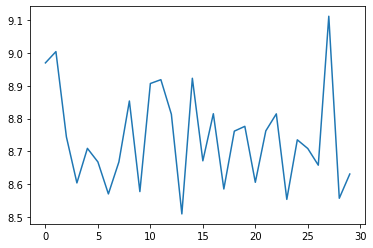

In [13]:
#Part8 训练集loss&验证集loss测试
import matplotlib.pyplot as plt
plt.plot(val_mean_loss)
#plt.plot(train_mean_loss)


,0
0,039937
1,"[[4, 8, 10, 10, 10], [8, 6, 10, 10, 10], [1, 1..."
